# Variational AutoEncoder with MNIST

http://www.renom.jp/notebooks/tutorial/generative-model/VAE/notebook.html

![VAE01](images/p_vae01.jpg)

![VAE02](images/p_vae02.jpg)

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [3]:
# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load MNIST Data

In [4]:
batch_size = 128
test_batch_size = 5

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/',
                            train=True,
                            transform=transform,
                            download=True)

test_data  = datasets.MNIST(root='~/.pytorch/MNIST_data/',
                            train=False,
                            transform=transform,
                            download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader  = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=test_batch_size,
                                           shuffle=False)

len(train_data)

60000

## Define Model

In [6]:
latent_size = 50

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            
            nn.Conv2d(16, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)     # 64*3*3
        )

        # mean vector
        self.f_mu = nn.Sequential(
            nn.Linear(64*3*3, 200),
            nn.Linear(200, latent_size)
        )
        
        # standard deviation vector
        self.f_std = nn.Sequential(
            nn.Linear(64*3*3, 200),
            nn.Linear(200, latent_size)
        )
        
        self.relu = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)        
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
                
    def encode(self, x) :
        out = self.encoder(x)
        out = out.view(-1, 64*3*3)
        out = self.relu(out)
        
        mu = self.f_mu(out)
        log_std = self.f_std(out)
        
        return mu, log_std
        
    def f_reparametrize(self, mu, log_std) :
        if self.training :
            std = log_std.exp()

            # random vector
            epsilon = torch.randn(std.shape).to(device)
            
            # z vector
            z = mu + std * epsilon

            return z
        
        else :
            return mu
        
    def forward(self, x):
        # x --> mu, std
        mu, log_std = self.encode(x)
        
        # mu, std --> z
        z = self.f_reparametrize(mu, log_std)
        
        return mu, log_std, z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_size, 200),
            nn.Linear(200, 64*3*3)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5, stride=2, padding=1),    # 64*3*3
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        out = self.fc(z)
        out = out.view(-1,64,3,3)
        
        out = self.decoder(out)
        out = self.sigmoid(out)
        
        out = out.view(-1,1,28,28)        
        
        return out

In [9]:
E = Encoder().to(device)
D = Decoder().to(device)

In [10]:
recon_loss = nn.BCELoss(reduction='sum')
# recon_loss = nn.MSELoss()

def vae_loss(recon_X, X, mu, log_std) :
    r_loss = recon_loss(recon_X, X)
    
    k_loss = -0.5 * torch.mean(1 + log_std - mu.pow(2) - log_std.exp())
#     k_loss /= batch_size
    
    total_loss = r_loss + k_loss
    
    return r_loss, k_loss, total_loss

In [11]:
# Encoder + Decoder 함께 학습
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

## Training

In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    
    total_batch = len(train_data) // batch_size

    R_loss = 0
    K_loss = 0
    total_loss = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.to(device)   # no flatten
        
        mu, log_std, z = E(X)
        pred = D(z)        
        
        r_loss, k_loss, cost = vae_loss(pred, X, mu, log_std)
        
        R_loss += r_loss.item()
        K_loss += k_loss.item()
        total_loss += cost.item()
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
    print('Epoch %d/%d, Loss: %.5f (Recon: %.5f | KLD: %.5f)'%
          (epoch+1, num_epochs, total_loss/total_batch, R_loss/total_batch, K_loss/total_batch))

Epoch 1/10, Loss: -31860.57678 (Recon: -31877.13917 | KLD: 16.56227)
Epoch 2/10, Loss: -45487.35716 (Recon: -45492.96060 | KLD: 5.60348)
Epoch 3/10, Loss: -46968.81804 (Recon: -46975.84121 | KLD: 7.02311)
Epoch 4/10, Loss: -49549.25410 (Recon: -49558.60570 | KLD: 9.35161)
Epoch 5/10, Loss: -50313.28805 (Recon: -50324.28025 | KLD: 10.99219)
Epoch 6/10, Loss: -50549.58580 (Recon: -50561.07718 | KLD: 11.49137)
Epoch 7/10, Loss: -50680.83841 (Recon: -50692.33805 | KLD: 11.49959)
Epoch 8/10, Loss: -50763.76986 (Recon: -50775.12438 | KLD: 11.35446)
Epoch 9/10, Loss: -50834.79706 (Recon: -50845.77684 | KLD: 10.97976)
Epoch 10/10, Loss: -50878.27054 (Recon: -50888.88886 | KLD: 10.61830)


## Generate images

In [13]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

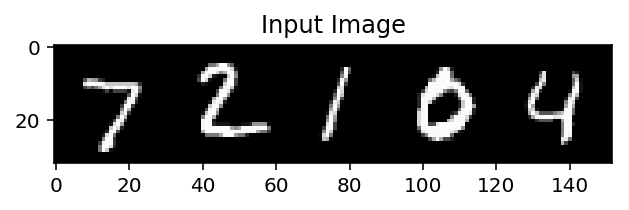

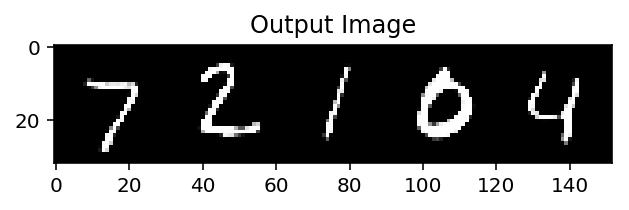

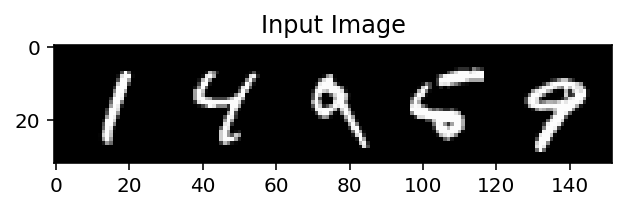

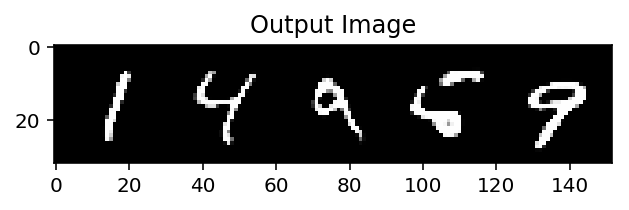

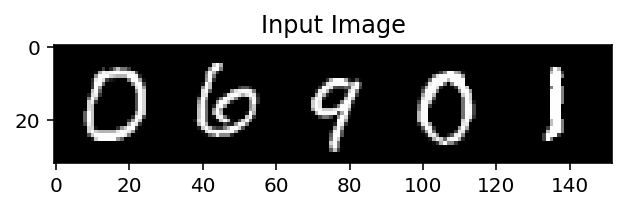

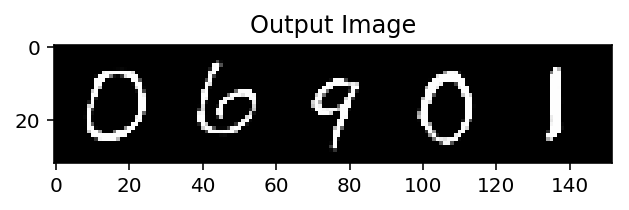

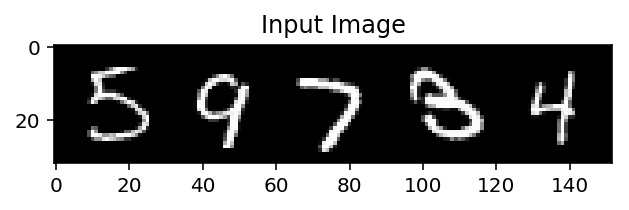

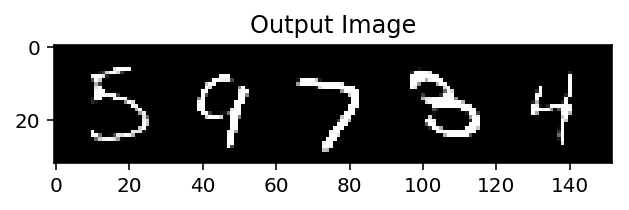

In [14]:
E.eval()
D.eval()

for i, (images, labels) in enumerate(test_loader):
    
    imshow(utils.make_grid(images, normalize=True), "Input Image")
    images  = images.view(test_batch_size, 1, 28, 28).to(device)
    
    mu, log_std, z = E(images)
    outputs = D(z)
    outputs = outputs.view(test_batch_size, 1, 28, 28)
    
    imshow(utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    print('=========================================')
    
    if i > 2 : break